In [3]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, classification_report, f1_score, recall_score
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

In [4]:
data = pd.read_csv('Data/25day_dataset.csv')

In [5]:
label = []
for i in range(len(data)):
    if data['wahing_machine'].iloc[i]==0 and data['dishwasher'].iloc[i]==0 and data['oven'].iloc[i]==0:
        label.append(0)
    elif data['wahing_machine'].iloc[i]>0:
        label.append(1)
    elif data['dishwasher'].iloc[i]>0:
        label.append(2)
    elif data['oven'].iloc[i]>0:
        label.append(3)
data['Class'] = label

KMeans: Funzioni per il calcolo ottimale del numero di Cluster da utilizzare e per il plot del metodo del gomito 

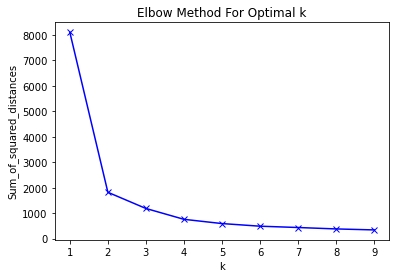

In [267]:
def KMeans_cluster_number(data, test_set_list):
    Sum_of_squared_distances = []
    K = range(1,10)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(data)
        Sum_of_squared_distances.append(km.inertia_)
        
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
KMeans_cluster_number(data, test_set_list)

Funzione per l'aggiunta delle etichette del relativo cluster e la distanza dai centroidi degli altri cluster come feature aggiuntive. Il numero di cluster ottimale è rappresentato dal gomito nel grafico precedente

In [6]:
def add_Clustering_labels(k, data):
    X = data.drop(['DateTime', 'Class', 'wahing_machine', 'dishwasher', 'oven'], axis=1)
    kmeans = KMeans(n_clusters=k)
    X["Cluster"] = kmeans.fit_predict(X)
    X["Cluster"] = X["Cluster"].astype('category')
    X_cd = kmeans.fit_transform(X)
    X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
    X = pd.concat([X, X_cd], axis=1)
    data['Cluster']= X.Cluster
    for col in X_cd:
        data[f'{col}']= X_cd[col]  
add_Clustering_labels(2, data)

In [7]:
Test_set1 =data[data['DateTime'].str.startswith('2022-01-01')]
Test_set2 =data[data['DateTime'].str.startswith('2022-01-02')]
Test_set3 =data[data['DateTime'].str.startswith('2022-01-03')]
Test_set4 =data[data['DateTime'].str.startswith('2022-01-04')]
Test_set5 =data[data['DateTime'].str.startswith('2022-01-05')]
Test_set6 =data[data['DateTime'].str.startswith('2022-01-06')]
Test_set7 =data[data['DateTime'].str.startswith('2022-01-07')]
Test_set8 =data[(data['DateTime'].str.startswith('2022-01-08')) | (data['DateTime'].str.startswith('2022-01-09'))]
Test_set9 =data[(data['DateTime'].str.startswith('2022-01-10')) | (data['DateTime'].str.startswith('2022-01-11'))]
Test_set10 =data[(data['DateTime'].str.startswith('2022-01-12')) | (data['DateTime'].str.startswith('2022-01-13'))]
test_set_list= [Test_set1, Test_set2, Test_set3, Test_set4, Test_set5, Test_set6, Test_set7, Test_set8, Test_set9, Test_set10]

In [8]:
def create_Training_set(data, test_set_list):
    Training_set = data.copy()
    for i in range(len(test_set_list)):
        Training_set.drop(test_set_list[i].index, axis=0, inplace=True)
    return Training_set

In [9]:
df = create_Training_set(data, test_set_list)
X = df.drop(['DateTime', 'Class', 'wahing_machine', 'dishwasher', 'oven'], axis=1)
y = df.Class

Funizone per il training (esterno con le nuove etichette aggiunte con il clustering) del modello 
che poi viene testato su tutte le fol

In [10]:
def train_Kmeans(X, y, test_set_list):
    two= int((y.values == 2).sum())
    three= int((y.values == 3).sum())
    undersample = RandomUnderSampler(sampling_strategy={0: 10000, 1: 10000, 2: two, 3: three})
    X_new, y_new = undersample.fit_resample(X, y)
    
    clf = RandomForestClassifier(max_depth=20, n_estimators = 15, max_features=5)
    clf.fit(X_new, y_new)
    return clf

def test_performance(test_set_list, clf):
    f_score={}
    recall={}
    for i in range(len(test_set_list)):
        y_test = test_set_list[i].Class
        y_preds = clf.predict(test_set_list[i].drop(['DateTime','Class', 'wahing_machine', 'dishwasher', 'oven'], axis=1))
        print("CM:\n" + str(confusion_matrix(y_preds,y_preds)) + "\n")
        print(classification_report(y_test,y_preds))
        r = recall_score(y_test,y_preds, average= None) 
        f = f1_score(y_test,y_preds, average= None)
        f_score[i] = f
        recall[i] = r 
    f = pd.DataFrame.from_dict(f_score, orient='index').replace(0, np.nan)
    print(f.mean(axis=0, skipna=True))
    r = pd.DataFrame.from_dict(recall, orient='index').replace(0, np.nan)
    print(r.mean(axis=0, skipna=True))
    

clf = train_Kmeans(X, y, test_set_list)
test_performance(test_set_list, clf)

CM:
[[78963     0     0     0]
 [    0  5795     0     0]
 [    0     0  1100     0]
 [    0     0     0   542]]

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     81665
           1       0.69      0.98      0.81      4053
           2       0.00      0.00      0.00         0
           3       0.99      0.79      0.88       682

    accuracy                           0.96     86400
   macro avg       0.67      0.68      0.67     86400
weighted avg       0.98      0.96      0.97     86400

CM:
[[76163     0     0     0]
 [    0  8220     0     0]
 [    0     0   510     0]
 [    0     0     0  1507]]



C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     78269
           1       0.82      0.96      0.89      7008
           2       0.00      0.00      0.00         0
           3       0.69      0.93      0.79      1123

    accuracy                           0.97     86400
   macro avg       0.63      0.71      0.66     86400
weighted avg       0.98      0.97      0.97     86400

CM:
[[69629     0     0     0]
 [    0 13449     0     0]
 [    0     0  3021     0]
 [    0     0     0   301]]

              precision    recall  f1-score   support

           0       0.99      0.85      0.91     81095
           1       0.07      0.95      0.13      1024
           2       0.86      0.72      0.78      3577
           3       0.96      0.41      0.58       704

    accuracy                           0.84     86400
   macro avg       0.72      0.73      0.60     86400
weighted avg       0.97      0.84      0.89     86400

CM:
[[79011     

C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

              precision    recall  f1-score   support

           0       1.00      0.82      0.90     82735
           1       0.19      0.97      0.32      3665
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.82     86400
   macro avg       0.30      0.45      0.30     86400
weighted avg       0.96      0.82      0.87     86400

CM:
[[77928     0     0     0]
 [    0  5746     0     0]
 [    0     0  2720     0]
 [    0     0     0     6]]

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     82422
           1       0.00      0.00      0.00         0
           2       0.96      0.66      0.78      3978
           3       0.00      0.00      0.00         0

    accuracy                           0.93     86400
   macro avg       0.49      0.40      0.44     86400
weighted avg       0.99      0.93      0.96     86400

CM:
[[80317     

C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

CM:
[[158639      0      0      0]
 [     0   9156      0      0]
 [     0      0   4002      0]
 [     0      0      0   1003]]

              precision    recall  f1-score   support

           0       0.99      0.98      0.98    160917
           1       0.77      0.95      0.85      7444
           2       0.70      0.77      0.73      3633
           3       0.18      0.22      0.20       806

    accuracy                           0.97    172800
   macro avg       0.66      0.73      0.69    172800
weighted avg       0.97      0.97      0.97    172800

CM:
[[163633      0      0      0]
 [     0   7337      0      0]
 [     0      0    793      0]
 [     0      0      0   1037]]

              precision    recall  f1-score   support

           0       0.99      0.97      0.98    168231
           1       0.37      0.98      0.54      2790
           2       0.00      0.00      0.00         0
           3       0.97      0.57      0.72      1779

    accuracy                     

C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\massi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1

CM:
[[155835      0      0      0]
 [     0   9329      0      0]
 [     0      0   5068      0]
 [     0      0      0   2568]]

              precision    recall  f1-score   support

           0       0.99      0.97      0.98    159922
           1       0.68      0.98      0.80      6490
           2       0.63      0.92      0.75      3463
           3       0.95      0.83      0.88      2925

    accuracy                           0.97    172800
   macro avg       0.81      0.92      0.85    172800
weighted avg       0.97      0.97      0.97    172800

0    0.964450
1    0.645307
2    0.759895
3    0.685143
dtype: float64
0    0.938961
1    0.964717
2    0.766190
3    0.611808
dtype: float64


La PCA è stata provata per fare una nuova feature extraction, ma essendo i dati non scalati 

    X = data.iloc[:, 1:13]
    std_scl = StandardScaler()
    X_std = std_scl.fit_transform(X)

    pca = decomposition.PCA(n_components=5)
    X_std_pca = pca.fit_transform(X)
    print(X_std_pca.shape)
    X_std_pca
    pd.concat([data, pd.DataFrame(X_std_pca)], axis=1)